In [2]:

from pathlib import Path

from hloc import (
    extract_features,
    match_features,
    reconstruction,
    visualization,
    pairs_from_retrieval,
)

import torch
torch.cuda.set_device(1)

See all available feature extraction methods (both local and global)

In [14]:
print(extract_features.confs.keys())
for key in extract_features.confs.keys():
    print(key, "\t" ,extract_features.confs[key])

dict_keys(['superpoint_aachen', 'superpoint_max', 'superpoint_inloc', 'r2d2', 'd2net-ss', 'sift', 'sosnet', 'disk', 'dir', 'netvlad', 'openibl', 'eigenplaces'])
superpoint_aachen 	 {'output': 'feats-superpoint-n4096-r1024', 'model': {'name': 'superpoint', 'nms_radius': 3, 'max_keypoints': 4096}, 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
superpoint_max 	 {'output': 'feats-superpoint-n4096-rmax1600', 'model': {'name': 'superpoint', 'nms_radius': 3, 'max_keypoints': 4096}, 'preprocessing': {'grayscale': True, 'resize_max': 1600, 'resize_force': True}}
superpoint_inloc 	 {'output': 'feats-superpoint-n4096-r1600', 'model': {'name': 'superpoint', 'nms_radius': 4, 'max_keypoints': 4096}, 'preprocessing': {'grayscale': True, 'resize_max': 1600}}
r2d2 	 {'output': 'feats-r2d2-n5000-r1024', 'model': {'name': 'r2d2', 'max_keypoints': 5000}, 'preprocessing': {'grayscale': False, 'resize_max': 1024}}
d2net-ss 	 {'output': 'feats-d2net-ss', 'model': {'name': 'd2net', 'multiscale': Fa

In [15]:
print(match_features.confs.keys())
for key in match_features.confs.keys():
    print(key, "\t" ,match_features.confs[key])

dict_keys(['superpoint+lightglue', 'disk+lightglue', 'superglue', 'superglue-fast', 'NN-superpoint', 'NN-ratio', 'NN-mutual', 'adalam'])
superpoint+lightglue 	 {'output': 'matches-superpoint-lightglue', 'model': {'name': 'lightglue', 'features': 'superpoint'}}
disk+lightglue 	 {'output': 'matches-disk-lightglue', 'model': {'name': 'lightglue', 'features': 'disk'}}
superglue 	 {'output': 'matches-superglue', 'model': {'name': 'superglue', 'weights': 'outdoor', 'sinkhorn_iterations': 50}}
superglue-fast 	 {'output': 'matches-superglue-it5', 'model': {'name': 'superglue', 'weights': 'outdoor', 'sinkhorn_iterations': 5}}
NN-superpoint 	 {'output': 'matches-NN-mutual-dist.7', 'model': {'name': 'nearest_neighbor', 'do_mutual_check': True, 'distance_threshold': 0.7}}
NN-ratio 	 {'output': 'matches-NN-mutual-ratio.8', 'model': {'name': 'nearest_neighbor', 'do_mutual_check': True, 'ratio_threshold': 0.8}}
NN-mutual 	 {'output': 'matches-NN-mutual', 'model': {'name': 'nearest_neighbor', 'do_mutu

Set location of images and output

In [3]:
images = Path("/mnt/ssd2/victor/kapture/Extended-CMU-Seasons/slice7/mapping/sensors/records_data/cam0/")
outputs = Path("/mnt/ssd2/victor/kapture/Extended-CMU-Seasons/slice7/hloc/mapping/cam0/")

sfm_pairs = outputs / "pairs-netvlad.txt"
sfm_dir = outputs / "sfm_superpoint+superglue"

retrieval_conf = extract_features.confs["netvlad"]
feature_conf = extract_features.confs["superpoint_max"]
matcher_conf = match_features.confs["superglue"]

Print current extractors:

In [5]:
print(feature_conf)
print(retrieval_conf)

{'output': 'feats-superpoint-n4096-rmax1600', 'model': {'name': 'superpoint', 'nms_radius': 3, 'max_keypoints': 4096}, 'preprocessing': {'grayscale': True, 'resize_max': 1600, 'resize_force': True}}
{'output': 'global-feats-netvlad', 'model': {'name': 'netvlad'}, 'preprocessing': {'resize_max': 1024}}


Extract global features (if not already extracted in the specified folder)

In [6]:
retrieval_path = extract_features.main(retrieval_conf, images, outputs)
pairs_from_retrieval.main(retrieval_path, sfm_pairs, num_matched=5)

[2024/02/06 10:07:16 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2024/02/06 10:07:16 hloc INFO] Found 190 images in root /mnt/ssd2/victor/kapture/Extended-CMU-Seasons/slice7/mapping/sensors/records_data/cam0.
[2024/02/06 10:07:16 hloc INFO] Skipping the extraction.
[2024/02/06 10:07:16 hloc INFO] Extracting image pairs from a retrieval database.
[2024/02/06 10:07:19 hloc INFO] Found 950 pairs.


Extract local features

In [7]:
feature_path = extract_features.main(feature_conf, images, outputs)
match_path = match_features.main(
    matcher_conf, sfm_pairs, feature_conf["output"], outputs
)

[2024/02/06 10:07:24 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-rmax1600',
 'preprocessing': {'grayscale': True, 'resize_force': True, 'resize_max': 1600}}
[2024/02/06 10:07:24 hloc INFO] Found 190 images in root /mnt/ssd2/victor/kapture/Extended-CMU-Seasons/slice7/mapping/sensors/records_data/cam0.
[2024/02/06 10:07:25 hloc INFO] Skipping the extraction.
[2024/02/06 10:07:25 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
[2024/02/06 10:07:25 hloc INFO] Skipping the matching.


Run SfM Reconstruction

In [7]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, feature_path, match_path)

[2024/02/01 18:39:05 hloc INFO] Creating an empty database...
[2024/02/01 18:39:05 hloc INFO] Importing images into the database...
[2024/02/01 18:39:07 hloc INFO] Importing features into the database...
100%|██████████| 190/190 [00:00<00:00, 1794.88it/s]
[2024/02/01 18:39:07 hloc INFO] Importing matches into the database...
100%|██████████| 950/950 [00:00<00:00, 2381.45it/s]
[2024/02/01 18:39:08 hloc INFO] Performing geometric verification of the matches...
I20240201 18:39:08.207726 2821634 misc.cc:198] 
Custom feature matching
I20240201 18:39:08.216228 2821634 feature_matching.cc:1021] Matching block [1/1]
I20240201 18:39:09.914680 2821634 feature_matching.cc:46]  in 1.698s
I20240201 18:39:09.934424 2821634 timer.cc:91] Elapsed time: 0.029 [minutes]
[2024/02/01 18:39:09 hloc INFO] Running 3D reconstruction...
I20240201 18:39:09.977541 2821777 misc.cc:198] 
Loading database
I20240201 18:39:09.979084 2821777 database_cache.cc:54] Loading cameras...
I20240201 18:39:09.979333 2821777 dat

2D visualizations. For 3D view, load the resulting model into Colmap.

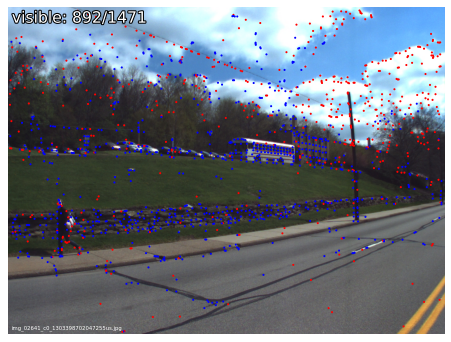

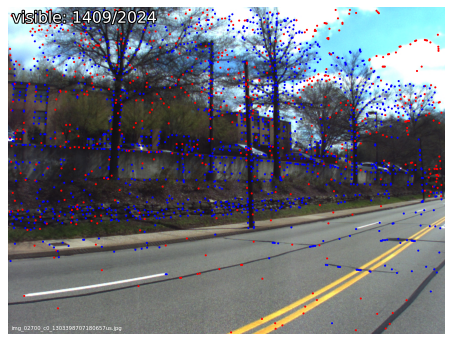

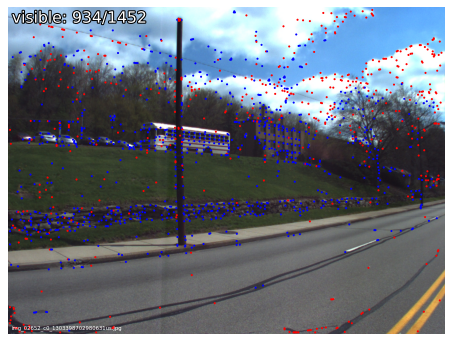

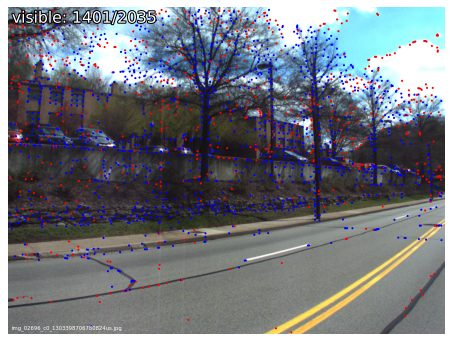

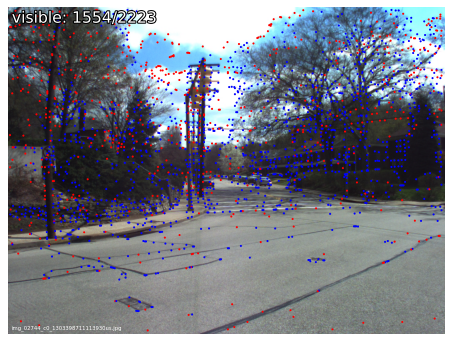

In [8]:
visualization.visualize_sfm_2d(model, images, color_by="visibility", n=5)